# Step 4 - Application Refused EDA and Modelling
## Goals in this Notebook
In this notebook, we will tackle the second potential business problem defined in the project's plan - predict the "NAME_CONTRACT_STATUS" in the previous_application table. This feature indicates whether the application was approved, cancelled, refused.
To achieve this, we will:
- Define the target of our model.
- Perform EDA.
- Do statistical inference.
- Create a model to predict the defined target.
- Test and deploy the model on Google Cloud.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import constants
import seaborn as sns
import functions
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import PrecisionRecallDisplay, log_loss
from sklearn.model_selection import StratifiedKFold
from category_encoders import TargetEncoder
import xgboost as xgb
import shap
import scikitplot
import pickle
from joblib import dump

## Load in Data

In [2]:
df_prev_app = pd.read_parquet(r"data\train\df_prev_app.parquet", engine="pyarrow")
df_cash = pd.read_parquet(r"data\train\df_cash.parquet", engine="pyarrow")
df_inst = pd.read_parquet(r"data\train\df_inst.parquet", engine="pyarrow")
df_cred = pd.read_parquet(r"data\train\df_cred.parquet", engine="pyarrow")

We will be looking to predict the status of a loan, let's first see the distribution of this target.

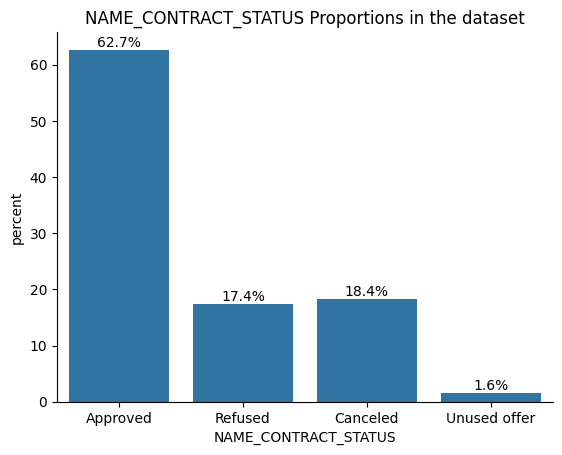

In [3]:
sns.countplot(df_prev_app.fillna(-1), x="NAME_CONTRACT_STATUS", stat="percent")
functions.add_labels(fmt="%2.1f%%")
plt.title("NAME_CONTRACT_STATUS Proportions in the dataset")
sns.despine()

Assumption: Approved and Unused offer loans share the fact that they were approved, and the applications are no different for the approval process.

Assumption: Canceled loans may be canceled at any time, perhaps before approving/refusing, therefore these loans will not be considered for the problem at hand.

Assumptions' implications: our target becomes binary - Refused or Not refused.

In [4]:
df_prev_app = df_prev_app[~(df_prev_app["NAME_CONTRACT_STATUS"] == "Canceled")]
df_prev_app["NAME_CONTRACT_STATUS_Refused"] = np.where(
    df_prev_app["NAME_CONTRACT_STATUS"] == "Refused", 1, 0
)

## SweetViz

This time, let's use sweetviz library to quickly perform some EDA charts.

In [5]:
# TAKES 15mins TO RUN
# import sweetviz as sv
# report = sv.analyze(
#     [df_prev_app, "Train"], target_feat="NAME_CONTRACT_STATUS_Refused"
# )
# report.show_html('Refused_sweetviz.html')

## EDA

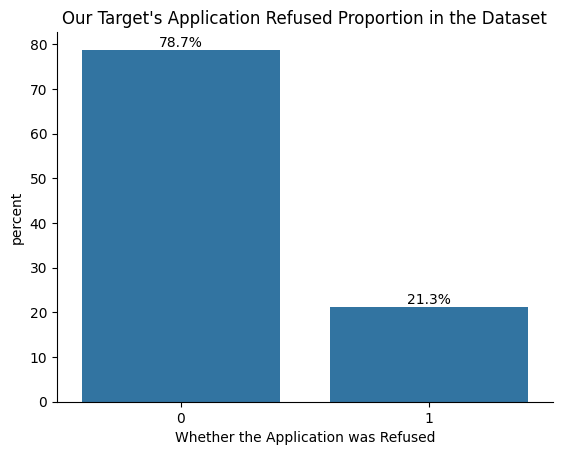

In [6]:
sns.countplot(df_prev_app, x="NAME_CONTRACT_STATUS_Refused", stat="percent")
functions.add_labels(fmt="%2.1f%%")
plt.title("Our Target's Application Refused Proportion in the Dataset")
plt.xlabel("Whether the Application was Refused")
sns.despine()

Refer to the Refused_sweetviz.html. I will be referring to figures by number which can be found on the far left of the screen.

- Target has 21% positive class, which means we are dealing with a slightly imbalanced classification problem.
- Figure 1 indicates that there may be a **time-dependant** pattern in the data.
- Figure 3 seems to tell us that consumer loans rarely get rejected, while those 28 applications with a missing type for a loan are all rejected.
- Figures 4-8 show continuos features with a heavy skew to the right. Most exhibit some positive relationship with the target. AMT_APPLICATION, AMT_CREDIT, AMT_GOODS_PRICE are **closely correlated**. **0 values** in these features are concerning, they may mean missing value or something else.
- Figures 9 and 10 are interesting from analysis standpoint since they show that more applications are approved when the process starts on the weekend or in the evening. However, I'm not certain about this relationship - do more trustworthy applicant apply for a loan during this time? Or is there some other variable at play?
- Figures 11 and 12 show features that are heavily **dominated by one class**. This may influence the usability of the features, but otherwise the look like good predictors.
- In figure 13 we see the normalised interest rate. Most of the loans are low-interest and the largest proportion of rejected loans are in here. **0 values** in the RATE_DOWN_PAYMENT feature is concerning.
- Figures 14-15 contain very empty features and will be **dropped**.
- Figure 16 shows that the purpose of a loan may influence the decision to approve. This could be **statistically tested**.
- NAME_CONTRACT_STATUS shown in figure 17 will be **dropped**.
- Figure 18 is interesting from EDA side because it indicates that there may be a **time-dependant** pattern in the data. Recently, the company received many more applications and th rejected proportion rose sharply.
- Figure 19 shows the distribution of the NAME_PAYMENT_TYPE. Only XNA seem to have any influence and I feel reluctant to use the features, thus it will be **dropped**.
- Figure 20 provides info on the secondary target - CODE_REJECT_REASON. Seems that rejected loans can have a variety of different codes, except "XAP" and "Client".
- Figure 21 tells us that most clients apply unaccompanied and this group has the biggest proportion of rejects.
- Figure 22 is interesting from EDA side as it seems that most applicants are repeaters, but they also receive the most rejects. From this figure alone, it seems that new applicants are favored over repeaters.
- Figure 23 exhibits the NAME_GOODS_CATEGORY feature's distribution. Nearly half of the applications are missing a value for this feature and those applications have a high proportion of rejects. It could be interesting to do a **statistical test** on the non-missing category applications.
- NAME_PORTFOLIO shown in figure 24 seems to have a lot of the same info as NAME_CONTRACT_TYPE (MI 0.96) and NAME_PRODUCT_TYPE (MI 0.74) and thus is a **candidate to be dropped**.
- SELLERPLACE_AREA seems to have **-1 as missing value**.
- Figure 29 effectively shows the term of the loan. The distribution is quite wide, with higher-term loans being more frequent to be rejected. Also, there are some **0 values** in the CNT_PAYMENT feature, which is concerning.
- In figure 31 we can see that PRODUCT_COMBINATION holds a lot of info on the other features: NAME_CONTRACT_TYPE (MI 1.00), NAME_PRODUCT_TYPE (MI 0.91), NAME_PORTFOLIO (MI 0.91) and others. I feel that it may be quite influential feature and should only be dropped during feature selection.
- Figures 32-36 encode days information that doesn't seem influential to the problem at hand and will be **dropped**.
- The last feature NFLAG_INSURED_ON_APPROVAL hold info only on the approved loans and should be **dropped** for the problem at hand.


## Statistical Inference

### Loan Purpose Influence on Loan Approval

Population: the whole dataset where feature NAME_CASH_LOAN_PURPOSE is not XAP or XNA.

Null hypothesis: the distributions of application refusal rates within the different purposes are drawn from the same distribution.

Alternative hypothesis: the distributions of application refusal rates are different.

Significance level: 95%.

In [7]:
population_filter = ~df_prev_app["NAME_CASH_LOAN_PURPOSE"].isin(["XAP", "XNA"])
population = df_prev_app[population_filter]
pop_grouped = (
    population.groupby("NAME_CASH_LOAN_PURPOSE")["NAME_CONTRACT_STATUS_Refused"]
    .mean()
    .sort_values()
)
pop_grouped

NAME_CASH_LOAN_PURPOSE
Purchase of electronic equipment    0.434483
Everyday expenses                   0.473467
Money for a third person            0.500000
Education                           0.503586
Medicine                            0.515581
Journey                             0.533673
Furniture                           0.541118
Car repairs                         0.547287
Other                               0.555910
Urgent needs                        0.565326
Wedding / gift / holiday            0.568548
Gasification / water supply         0.581197
Repairs                             0.622697
Hobby                               0.634146
Business development                0.680000
Buying a used car                   0.684048
Buying a garage                     0.704762
Building a house or an annex        0.734979
Buying a holiday home / land        0.747100
Buying a home                       0.754687
Buying a new car                    0.759352
Refusal to name the goal        

Evidently, paying on other loans, refusing to name the purpose or requesting a loan for a big purchase seems to increase the chance of a loan being rejected.

It would be interesting to also see the median loan amount requested here.

In [8]:
pop_grouped = population.groupby("NAME_CASH_LOAN_PURPOSE").agg(
    {"NAME_CONTRACT_STATUS_Refused": "mean", "AMT_APPLICATION": "median"}
)
pop_grouped.sort_values("NAME_CONTRACT_STATUS_Refused")

,NAME_CONTRACT_STATUS_Refused,AMT_APPLICATION
NAME_CASH_LOAN_PURPOSE,,
Purchase of electronic equipment,0.434483,135000.0
Everyday expenses,0.473467,135000.0
Money for a third person,0.500000,168750.0
Education,0.503586,135000.0
Medicine,0.515581,180000.0
Journey,0.533673,225000.0
Furniture,0.541118,225000.0
Car repairs,0.547287,180000.0
Other,0.555910,225000.0


From this augmented table we can see that the reason why loans get rejected may not be the loan purpose, but a confounding variable - the loan amount. To combat this factor a bit, we will only take the purposes which have 225000.0 median amount, as this amount seems to be most prevalent amongst the groups.

Thus, we redefine the population: the whole dataset where feature NAME_CASH_LOAN_PURPOSE is not XAP or XNA and the median loan amount is 225000.

In [9]:
selected_purposes_filter = pop_grouped["AMT_APPLICATION"] == 225000.0
selected_purposes = pop_grouped[selected_purposes_filter].index
redefined_population = population[
    population["NAME_CASH_LOAN_PURPOSE"].isin(selected_purposes)
]
table = pd.crosstab(
    redefined_population["NAME_CASH_LOAN_PURPOSE"],
    redefined_population["NAME_CONTRACT_STATUS_Refused"],
).values
table

array([[ 279,  329],
       [  15,   26],
       [ 457,  523],
       [5568, 6970],
       [ 321,  423]], dtype=int64)

We created our contingency table and prepared for chi2 test. One of the classes is quite small, but it's still enough observations for a chi2. We aim for 95% significance.

In [10]:
chi, pval, _, _ = stats.chi2_contingency(table)
print(f"chi2 statistic: {chi:.2f}")
print(f"p-value: {pval:.4f}")

chi2 statistic: 3.91
p-value: 0.4186


The p-value is too large to reject the null. Perhaps it's the small class at play? Let's drop that group and try again, this time with 97.5% significance.

In [11]:
new_table = np.delete(table, 1, 0)
chi, pval, _, _ = stats.chi2_contingency(new_table)
print(f"chi2 statistic: {chi:.2f}")
print(f"p-value: {pval:.4f}")

chi2 statistic: 2.86
p-value: 0.4143


The p-value is basically the same. Thus, we fail to reject the null and have to stay with it.

### Goods Category Influence on Loan Approval

Population: the whole dataset where feature NAME_GOODS_CATEGORY is not XNA.

Null hypothesis: the distributions of application refusal rates within the different goods categories are drawn from the same distribution.

Alternative hypothesis: the distributions of application refusal rates are different.

Significance level: 95%.

Based on experience from the last test, I anticipate that we may need to account for a confounding variable - loan amount.

In [12]:
population_filter = ~df_prev_app["NAME_GOODS_CATEGORY"].isin(["XNA"])
population = df_prev_app[population_filter]
pop_grouped = (
    population.groupby("NAME_GOODS_CATEGORY")
    .agg({"NAME_CONTRACT_STATUS_Refused": "mean", "AMT_APPLICATION": "median"})
    .sort_values("NAME_CONTRACT_STATUS_Refused")
)
pop_grouped

,NAME_CONTRACT_STATUS_Refused,AMT_APPLICATION
NAME_GOODS_CATEGORY,,
Fitness,0.012500,99090.00
Other,0.047811,48397.50
Medicine,0.061375,163228.50
Gardening,0.072818,83245.50
Consumer Electronics,0.073266,73127.25
Medical Supplies,0.074593,159363.00
Furniture,0.079167,103927.50
Homewares,0.083027,121450.50
Sport and Leisure,0.084372,70875.00


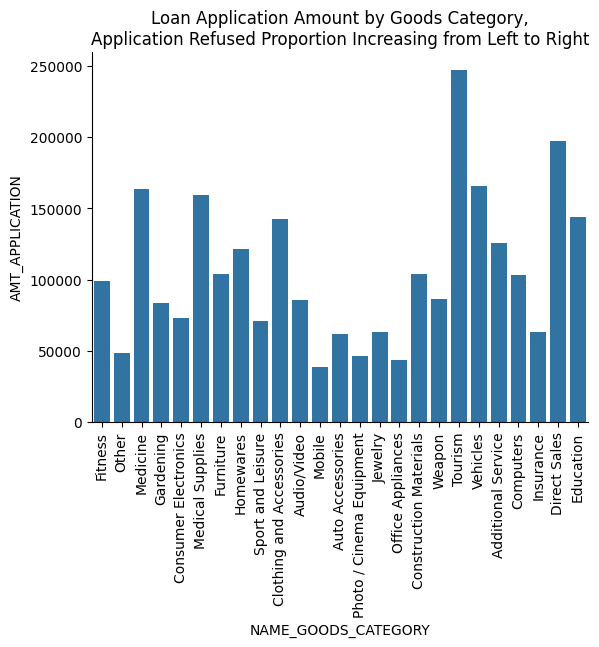

In [13]:
sns.barplot(pop_grouped, x=pop_grouped.index, y="AMT_APPLICATION")
plt.title(
    "Loan Application Amount by Goods Category,\nApplication Refused Proportion Increasing from Left to Right"
)
plt.xticks(rotation=90)
sns.despine()

It seems that the median application amount influence is not as severe in this case. I can still see that the groups that have the biggest medians seem to be on the high end of refusal rate, but they don't seem too extreme.

In [14]:
table = pd.crosstab(
    population["NAME_GOODS_CATEGORY"], population["NAME_CONTRACT_STATUS_Refused"]
).values
table

array([[    87,     11],
       [ 73794,   7333],
       [  5375,    554],
       [ 17048,   1585],
       [ 74555,  10954],
       [ 18323,   2024],
       [ 92249,   7293],
       [   266,     50],
       [    73,     14],
       [   158,      2],
       [ 39745,   3417],
       [  2050,    161],
       [  3744,    339],
       [    48,      8],
       [  4461,    462],
       [  2841,    229],
       [  1147,     75],
       [167385,  16652],
       [  1715,    181],
       [  2131,    107],
       [ 18716,   1930],
       [  2203,    203],
       [  1122,    132],
       [  2420,    287],
       [    52,      6]], dtype=int64)

Some of the groups are very small, and initially I was concerned with cell that has "2" in it. But based on [this article](https://statisticseasily.com/assumptions-for-chi-square/), "The expected frequency in each cell should be five or more in at least 80% of the cells." It is clear that we achieve this chi2 assumption, meaning we can proceed with the chi2 test.

In [15]:
chi, pval, _, _ = stats.chi2_contingency(table)
print(f"chi2 statistic: {chi:.2f}")
print(f"p-value: {pval:.4f}")

chi2 statistic: 2003.73
p-value: 0.0000


Our constructed test achieves a very big statistic and a very small p-value, which is well below our alpha. Therefore we reject the null and state that with 95% confidence different goods categories' loan application reject rates come from different distributions. However, there may be other confounding variables.

## Modelling

In [16]:
df = df_prev_app.drop(columns=constants.REFUSED_MODEL_COLS_TO_DROP)
# df.to_parquet("data/refused_model_df.parquet", engine="pyarrow")

At this moment, I tried using autoML library pycaret to create a baseline. Navigate to refused_pycaret.ipynb to see the outcome.

### Log Loss Baseline

Establish log loss baseline - predict mean proportion for every instance.

In [17]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
losses = list()
X = df.drop(columns=constants.REFUSED_MODEL_TARGETS)
y = df["NAME_CONTRACT_STATUS_Refused"]
for train_idx, eval_idx in cv.split(X, y):
    X_cv_train, y_cv_train = X.iloc[train_idx], y.iloc[train_idx]
    X_cv_eval, y_cv_eval = X.iloc[eval_idx], y.iloc[eval_idx]

    mean_train = y_cv_train.mean()
    y_pred = y_cv_eval.copy().astype(float)
    y_pred.iloc[:] = mean_train

    losses.append(log_loss(y_cv_eval, y_pred))

print(f"baseline log loss: {np.mean(losses):1.3f}")

baseline log loss: 0.517


### Preprocessor

I'll create a preprocessor meant to be used for trees, without imputing - gradient boosted trees handle these efficiently.

In [18]:
onehot_imputer = SimpleImputer(missing_values="XNA", strategy="most_frequent")
onehot_encoder = OneHotEncoder(
    drop="if_binary", handle_unknown="ignore", sparse_output=False
)
onehot_pipe = Pipeline(
    [
        ("encoder", onehot_encoder),
    ]
)
target_encoder = TargetEncoder(handle_missing="value")
target_pipe = Pipeline(
    [
        ("encoder", target_encoder),
    ]
)
onehot_features = constants.REFUSED_BINARY_COLUMNS + constants.REFUSED_ONE_HOT_COLUMNS
target_features = constants.REFUSED_TARGET_COLUMNS
passthrough_features = constants.REFUSED_PASSTHROUGH_COLUMNS
preprocessor = ColumnTransformer(
    [
        ("onehot_pipe", onehot_pipe, onehot_features),
        ("target_pipe", target_pipe, target_features),
        ("passthrough", "passthrough", passthrough_features),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [19]:
X_train_tf, y_train, X_valid_tf, y_valid = functions.preprocess_test_train(
    df.drop(columns="CODE_REJECT_REASON"),
    preprocessor,
    stratify="NAME_CONTRACT_STATUS_Refused",
)

### Initial Model and Explanation

log loss: 0.282


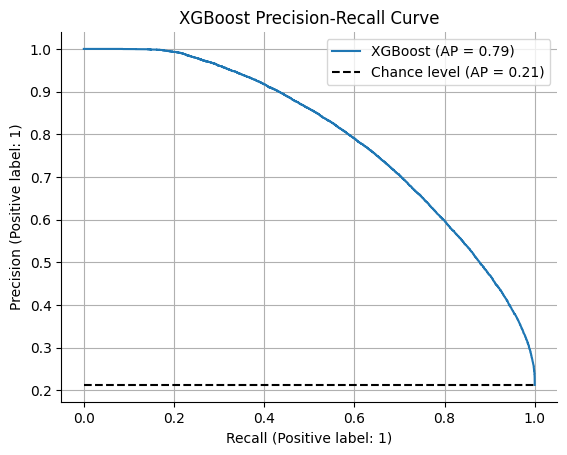

In [20]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.25,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)
functions.report_xgb_metrics(model, X_valid_tf, y_valid, "XGBoost")

Two observations to be made here: 
1) The problem turns out to be much easier than predicting TARGET in step3.
2) Our created model seems to perform better than the best autoML model.

[09:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


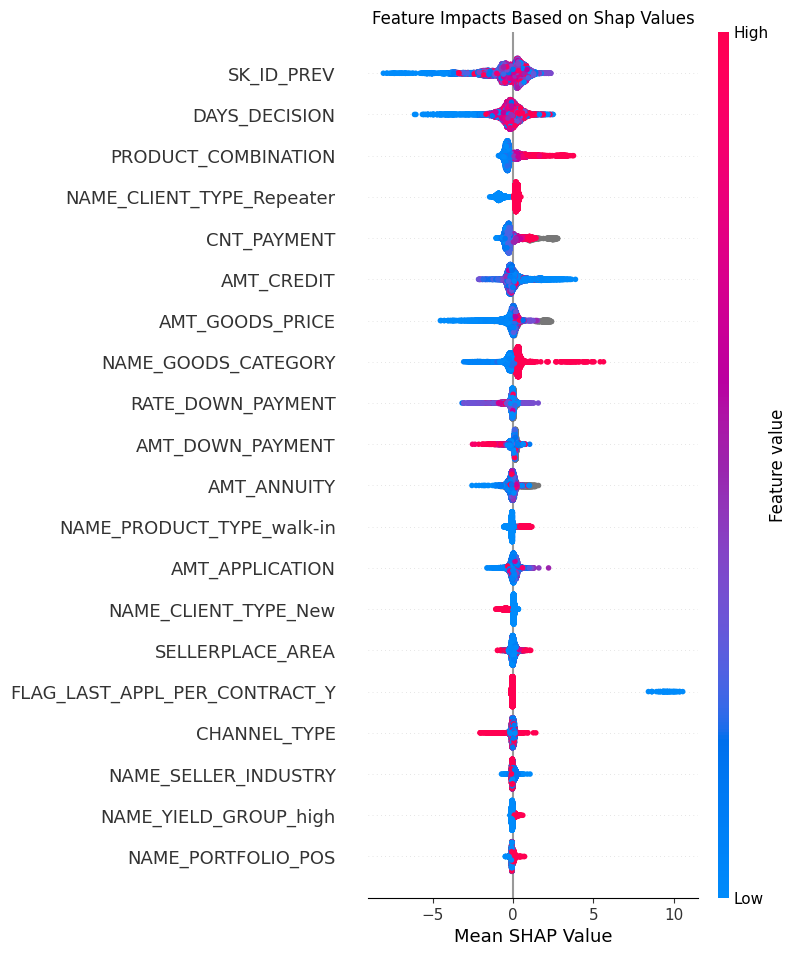

In [21]:
X_valid_tf_sample = X_valid_tf.sample(10000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_valid_tf_sample)

shap.summary_plot(shap_vals, X_valid_tf_sample, show=False)
plt.title("Feature Impacts Based on Shap Values")
plt.xlabel("Mean SHAP Value")
plt.show()

The shap values suggest that there are some patterns we observed in our EDA:
- The problem is very time-dependant.
- PRODUCT_COMBINATION seems to sum up the reject/approve problem fairly well.
- Loans with long term or without term specified ten do be rejected quite often.
- Repeater customers tend to be rejected more often.
- Goods category is an important feature for the problem. However, loan purpose seems not to be. We saw these during statistical inference.

In [22]:
# shap_importance_df = functions.get_shap_importance_df(X_valid_tf, shap_vals)
# shap_importance_df.to_excel("data/shap_refused.xlsx")

### Feature Selection

Currently we have 52 features. Looking at the shap_refused.xlsx, it seems that we should easily reduce to 40 features and have little impact on performance. 

Of course, the exact number of features would be estimated better by sequentially reducing the count of features and recording the performance, then plotting a figure.

In [23]:
REDUCE_TO = 40
print(f"Reducing feature number from {len(X_train_tf.columns)} to {REDUCE_TO}")
# selected_cols = functions.shap_sequentially_select(
#     X_train_tf,
#     y_train,
#     X_valid_tf,
#     y_valid,
#     reduce_to=REDUCE_TO,
#     learning_rate=0.3
# )
# with open("data/columns_40_refused.pkl", 'wb') as file:
#     pickle.dump(selected_cols, file)
with open("data/columns_40_refused.pkl", "rb") as file:
    selected_cols = pickle.load(file)
X_train_tf_40 = X_train_tf[selected_cols]
X_valid_tf_40 = X_valid_tf[selected_cols]

Reducing feature number from 52 to 40


log loss: 0.282


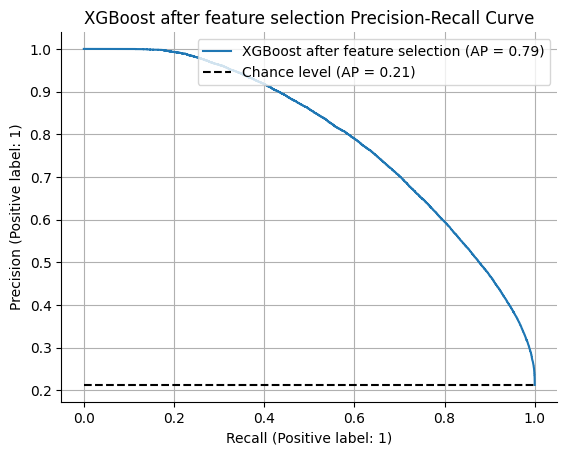

In [24]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.25,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf_40,
    y_train,
    eval_set=[(X_valid_tf_40, y_valid)],
    verbose=0,
)
functions.report_xgb_metrics(
    model, X_valid_tf_40, y_valid, "XGBoost after feature selection"
)

Looks like the feature selection was successful - our metrics stayed the same as they were.

#### Redefine Preprocessor

I'll redefine the preprocessor to account for the feature selection.

In [25]:
onehot_features = (
    constants.REFUSED_BINARY_COLUMNS + constants.REFUSED_ONE_HOT_COLUMNS_FEAT_SEL
)
preprocessor_encode = ColumnTransformer(
    [
        ("onehot_pipe", onehot_pipe, onehot_features),
        ("target_pipe", target_pipe, target_features),
        ("passthrough", "passthrough", passthrough_features),
    ],
    verbose_feature_names_out=False,
)
preprocessor_drop = ColumnTransformer(
    [
        ("drop", "drop", constants.REFUSED_FEAT_SEL_AFTER_PREP),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
preprocessor = Pipeline(
    [("encode", preprocessor_encode), ("drop", preprocessor_drop)]
).set_output(transform="pandas")

In [26]:
X_train_tf, y_train, X_valid_tf, y_valid = functions.preprocess_test_train(
    df.drop(columns="CODE_REJECT_REASON"),
    preprocessor,
    stratify="NAME_CONTRACT_STATUS_Refused",
)

### Final Model Selection

I have prepared the code to find the optimal xgboost parameters. However, I decided not to run it due to the time it takes to tune reliably. To cut this time shorter, in the future I would like to explore early stopping the non-promising rounds. I would imagine that then I would need to first select optimal learning rate.

In [27]:
# import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
#         gamma=trial.suggest_float("gamma", 1e-4, 5, log=True),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#         subsample=trial.suggest_float("subsample", 0.5, 1),
#         objective="binary:logistic",
#         n_estimators=10000,
#         early_stopping_rounds=20,
#         random_state=42,
#         seed=42,
#     )
#     model = xgb.XGBClassifier(**xgb_params)
#     cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#     losses = list()
#     X = df.drop(columns=constants.REFUSED_MODEL_TARGETS)
#     y = df["NAME_CONTRACT_STATUS_Refused"]
#     preprocessor_cv = Pipeline(
#         [
#             ("encode", preprocessor_encode),
#             ("drop", preprocessor_drop)
#         ]
#     )
#     for train_idx, eval_idx in cv.split(X, y):
#         X_cv_train, y_cv_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_cv_eval, y_cv_eval = X.iloc[eval_idx], y.iloc[eval_idx]

#         X_cv_train_tf = preprocessor_cv.fit_transform(X_cv_train, y_cv_train)
#         X_cv_eval_tf = preprocessor_cv.transform(X_cv_eval)
#         model.fit(
#             X_cv_train_tf, y_cv_train, eval_set=[(X_cv_eval_tf, y_cv_eval)], verbose=0
#         )
#         losses.append(model.best_score)
#     return np.mean(losses)

# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(objective, n_trials=100, n_jobs=-1)
# xgb_params = study.best_params
# with open("data/refused_xgbparams.pkl", "wb") as file:
#     pickle.dump(xgb_params, file)

# with open("data/refused_xgbparams.pkl", "rb") as file:
#     xgb_params = pickle.load(file)
# xgb_params

In [28]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=10000,
    learning_rate=0.2,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_train_tf, y_train), (X_valid_tf, y_valid)],
    verbose=0,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

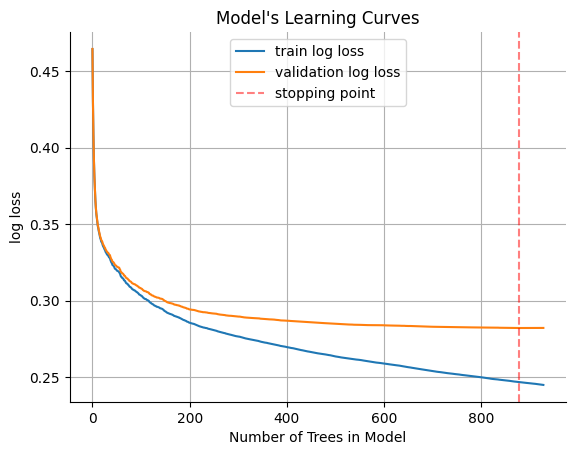

In [29]:
results = model.evals_result()
fig, ax = plt.subplots()
ax.plot(
    results["validation_0"]["logloss"],
    label="train log loss",
)
ax.plot(
    results["validation_1"]["logloss"],
    label="validation log loss",
)
ax.axvline(
    model.best_iteration, color="red", alpha=0.5, ls="--", label="stopping point"
)
ax.legend()
plt.title("Model's Learning Curves")
plt.ylabel("log loss")
plt.xlabel("Number of Trees in Model")
plt.grid()
sns.despine()

The model has early stopped, reaching it's peak performance.

[09:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


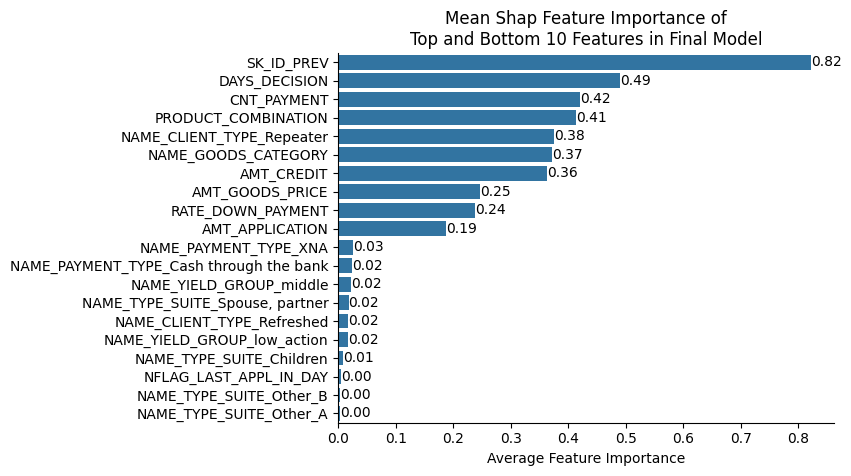

In [30]:
X_valid_tf_sample = X_valid_tf.sample(frac=0.1)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_valid_tf_sample)
shap_importance_df = functions.get_shap_importance_df(X_valid_tf_sample, shap_vals)
shap_importance_df_topntail = pd.concat(
    [shap_importance_df.head(10), shap_importance_df.tail(10)]
)

sns.barplot(shap_importance_df_topntail, y="col_name", x="shap_feature_importance")
plt.title("Mean Shap Feature Importance of\nTop and Bottom 10 Features in Final Model")
plt.xlabel("Average Feature Importance")
plt.ylabel("")
functions.add_labels(fmt="%1.2f")
sns.despine()

There's still a few unimportant features, and the top stayed pretty much the same as before.

### Final Model Threshold Selection

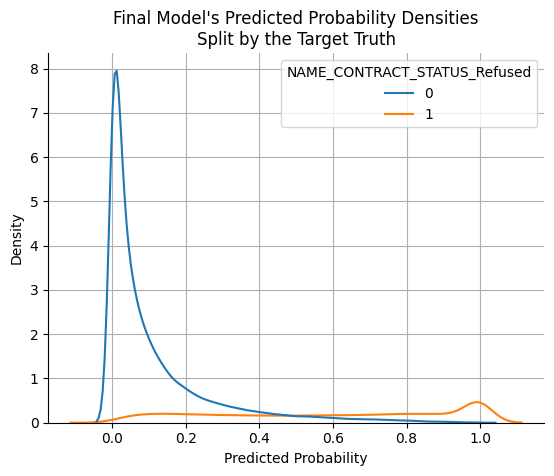

In [31]:
pred_proba = model.predict_proba(X_valid_tf)
proba_ser = pd.Series(pred_proba[:, 1], name="proba")
target_df = y_valid.reset_index()
target_df = target_df.join(proba_ser)
sns.kdeplot(target_df, x="proba", hue="NAME_CONTRACT_STATUS_Refused")
plt.grid()
plt.title("Final Model's Predicted Probability Densities\nSplit by the Target Truth")
plt.xlabel("Predicted Probability")
sns.despine()

In [32]:
target_df.groupby("NAME_CONTRACT_STATUS_Refused")["proba"].describe()

,count,mean,std,min,25%,50%,75%,max
NAME_CONTRACT_STATUS_Refused,,,,,,,,
0,172789.0,0.110107,0.155501,4.133355e-09,0.011380,0.047561,0.139547,0.999753
1,46637.0,0.587460,0.322243,3.568201e-04,0.293131,0.617209,0.897636,1.000000


The model is quite good, the density peaks are separated far apart.

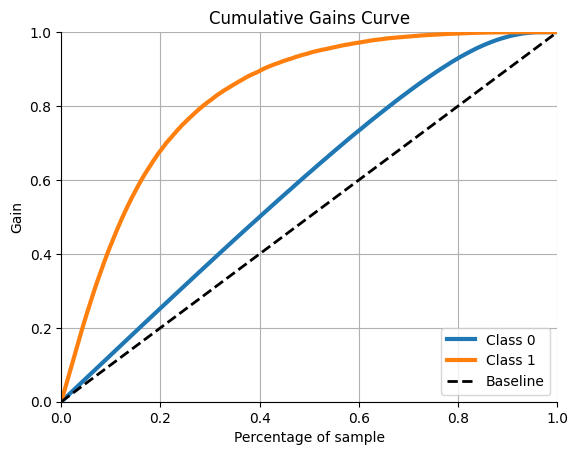

In [33]:
scikitplot.metrics.plot_cumulative_gain(y_valid, pred_proba)
sns.despine()

Positive class rises quite sharply. By investigating just 20% of the most probable applications, we would find around 70% of all the reject-worthy applications.

We can now select the optimal threshold using the same rule as the one we used in TARGET model.

Here Ixy is Income from a predicted x true y element in the confusion matrix:<br>
I00 = 0.2 (we gain the income from the account)<br>
I11 = 0 (we correctly reject, not losing any of the credit)<br>
I01 = -0.8 (assume that we lose 80% of the credit)<br>
I10 = -0.2 (we incorrectly reject losing potential income. From assumption, P10 = P01/4)

In [34]:
profit_dict = dict()
for thresh in np.arange(0, 1, 0.01):
    preds_loop = np.where(pred_proba[:, 1] > thresh, 1, 0)
    profit = functions.calculate_profit_TARGET(y_valid, preds_loop)
    profit_dict[thresh] = profit
profit_ser = pd.Series(profit_dict)
PROFITABLE_THRESHOLD = profit_ser.index[profit_ser.argmax()]

best_profit = profit_ser.loc[PROFITABLE_THRESHOLD]
prev_profit = profit_ser.loc[0.5]
profit_increase = best_profit * 100 / prev_profit - 100
print(
    f"With the default threshold of 0.5, the potential income would be {prev_profit:.2f} comparison units."
)
print(
    f"With the new threshold of {PROFITABLE_THRESHOLD:1.2f}, the potential income would be {best_profit:.2f} comparison units."
)
print(f"That's a {profit_increase:2.2f}% increase in profit.")

With the default threshold of 0.5, the potential income would be 16485.00 comparison units.
With the new threshold of 0.35, the potential income would be 17848.20 comparison units.
That's a 8.27% increase in profit.


              precision    recall  f1-score   support

           0       0.92      0.92      0.92    172789
           1       0.70      0.70      0.70     46637

    accuracy                           0.87    219426
   macro avg       0.81      0.81      0.81    219426
weighted avg       0.87      0.87      0.87    219426



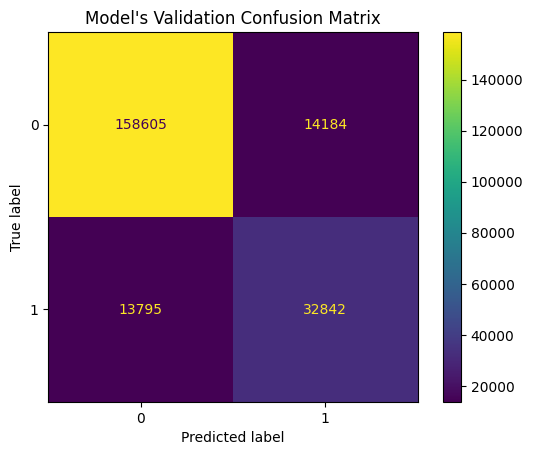

In [35]:
preds = np.where(pred_proba[:, 1] > PROFITABLE_THRESHOLD, 1, 0)
functions.report_classification_metrics(y_valid, preds)
plt.title("Model's Validation Confusion Matrix")
plt.show()

### Model's Influence

Let's see what impact our model has on different customers. We'll merge df_app to better understand who the customers are. Also, we'll take only the last years applications, so that the information would be more current.

In [36]:
df_app = pd.read_parquet(r"data\train\df_app.parquet", engine="pyarrow")

preds_df = pd.DataFrame(pred_proba, columns=["proba_0", "proba_1"])
preds_df = pd.concat(
    [preds_df, X_valid_tf["SK_ID_PREV"].reset_index(drop=True)], axis=1
)
preds_df = pd.merge(
    preds_df,
    df_prev_app[
        ["SK_ID_CURR", "SK_ID_PREV", "DAYS_DECISION", "NAME_CONTRACT_STATUS_Refused"]
    ],
    how="left",
    on="SK_ID_PREV",
)
preds_df = pd.merge(preds_df, df_app, how="left", on="SK_ID_CURR")
preds_df_year = preds_df[preds_df["DAYS_DECISION"] >= -365].copy()
preds_df_year["Prediction"] = np.where(
    preds_df_year["proba_1"] > PROFITABLE_THRESHOLD, 1, 0
)

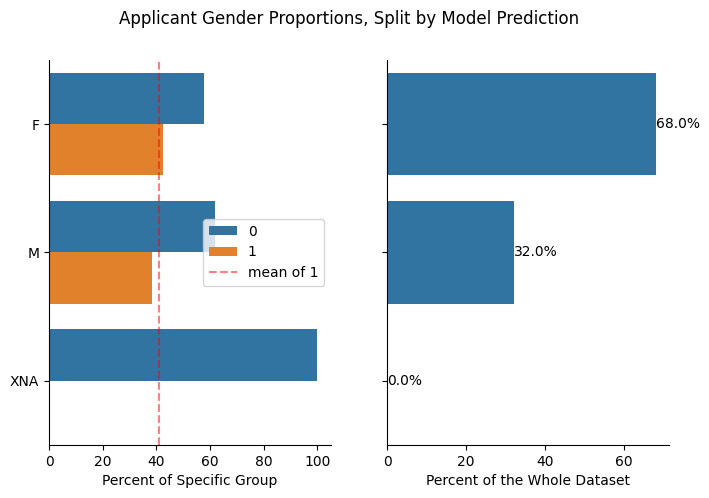

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
functions.norm_plot(preds_df_year, "CODE_GENDER", "Prediction", ax=ax)
plt.suptitle("Applicant Gender Proportions, Split by Model Prediction")
ax[0].legend(loc=5)
plt.show()

Female applications are rejected slightly more often.

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


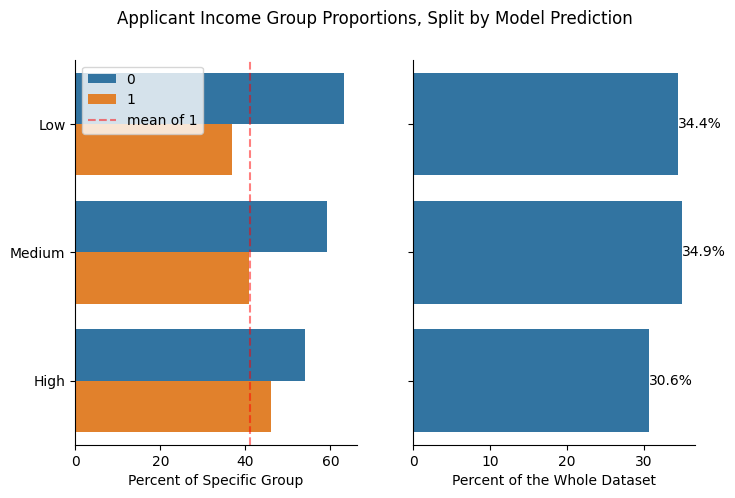

In [38]:
preds_df_year["Income Group"] = pd.qcut(
    preds_df_year["AMT_INCOME_TOTAL"], 3, labels=["Low", "Medium", "High"]
)
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
functions.norm_plot(preds_df_year, "Income Group", "Prediction", ax=ax)
plt.suptitle("Applicant Income Group Proportions, Split by Model Prediction")
plt.show()

Higher income applicant get rejected more frequently.

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


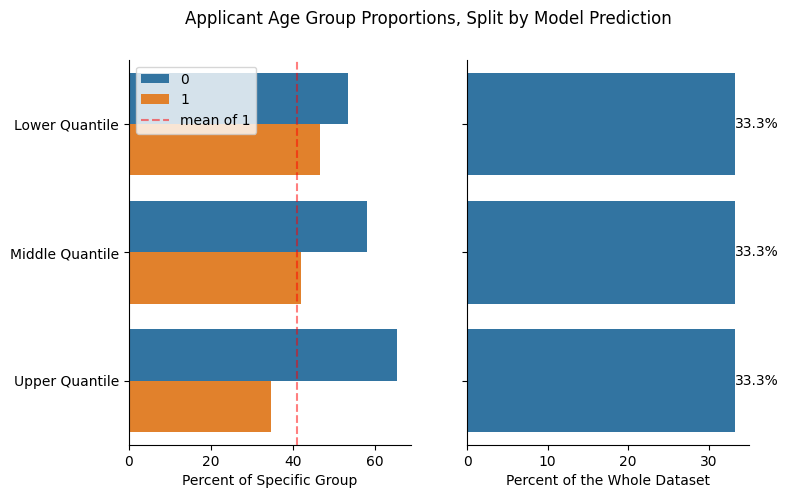

In [39]:
preds_df_year["Age Group"] = pd.qcut(
    preds_df_year["DAYS_BIRTH"],
    3,
    labels=["Lower Quantile", "Middle Quantile", "Upper Quantile"],
)
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
functions.norm_plot(preds_df_year, "Age Group", "Prediction", ax=ax)
plt.suptitle("Applicant Age Group Proportions, Split by Model Prediction")
plt.show()

Younger applicant get rejected more frequently.

All these figures show that there may be a bias towards some customer groups. Let's see if the bias exists in the original data.

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


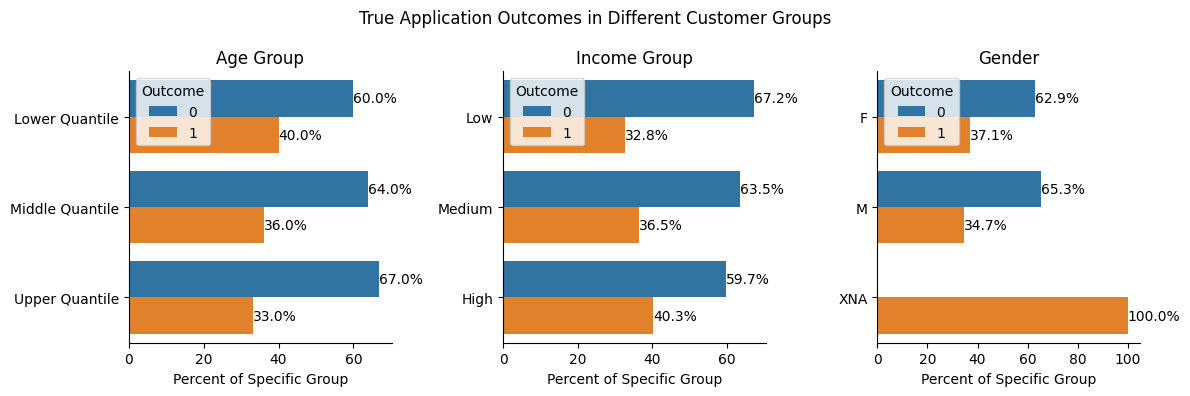

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


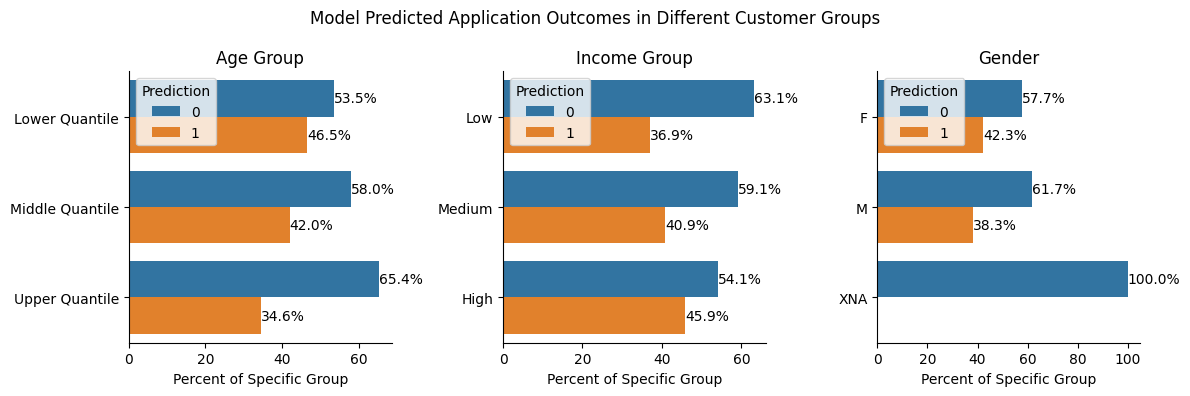

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
functions.norm_count_plot(
    preds_df_year, "Age Group", "NAME_CONTRACT_STATUS_Refused", ax=axs[0]
)
functions.norm_count_plot(
    preds_df_year, "Income Group", "NAME_CONTRACT_STATUS_Refused", ax=axs[1]
)
functions.norm_count_plot(
    preds_df_year, "CODE_GENDER", "NAME_CONTRACT_STATUS_Refused", ax=axs[2]
)
axs[0].set_title("Age Group")
axs[1].set_title("Income Group")
axs[2].set_title("Gender")
for ax in axs:
    ax.legend(title="Outcome", loc=2)
    functions.add_labels(ax=ax, fmt="%1.1f%%")
plt.suptitle("True Application Outcomes in Different Customer Groups")
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
functions.norm_count_plot(preds_df_year, "Age Group", "Prediction", ax=axs[0])
functions.norm_count_plot(preds_df_year, "Income Group", "Prediction", ax=axs[1])
functions.norm_count_plot(preds_df_year, "CODE_GENDER", "Prediction", ax=axs[2])
axs[0].set_title("Age Group")
axs[1].set_title("Income Group")
axs[2].set_title("Gender")
for ax in axs:
    ax.legend(title="Prediction", loc=2)
    functions.add_labels(ax=ax, fmt="%1.1f%%")
plt.suptitle("Model Predicted Application Outcomes in Different Customer Groups")
fig.tight_layout()
plt.show()

Original data has the pretty much the same bias and the model has picked up on it somehow. Perhaps the applications of some groups are on average worse than the other groups.

We can also see that the model would reject more applications than have been originally rejected.

### Retrain Selected Model on the Whole Dataset

In [41]:
X_train = df.drop(columns=constants.REFUSED_MODEL_TARGETS)
y_train = df["NAME_CONTRACT_STATUS_Refused"]

X_train_tf = preprocessor.fit_transform(X_train, y_train)

n_estimators = model.best_iteration

model_retrained = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=n_estimators,
    learning_rate=0.2,
    seed=42,
    random_state=42,
)
model_retrained.fit(
    X_train_tf,
    y_train,
    verbose=0,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=878, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [62]:
dump(preprocessor, "app_refused/models/refused_preprocessor_V1.joblib")

['app_refused/models/refused_preprocessor_V1.joblib']

In [63]:
dump(model_retrained, "app_refused/models/refused_model_V1.joblib")

['app_refused/models/refused_model_V1.joblib']

### Selected Model Testing

In [44]:
df_prev_app_test = pd.read_parquet(r"data\test\df_prev_app.parquet", engine="pyarrow")
df_prev_app_test = df_prev_app_test[
    ~(df_prev_app_test["NAME_CONTRACT_STATUS"] == "Canceled")
]
df_prev_app_test["NAME_CONTRACT_STATUS_Refused"] = np.where(
    df_prev_app_test["NAME_CONTRACT_STATUS"] == "Refused", 1, 0
)

X_test = df_prev_app_test.drop(columns=constants.REFUSED_MODEL_TARGETS)
y_test = df_prev_app_test["NAME_CONTRACT_STATUS_Refused"]

X_test_tf = preprocessor.transform(X_test)

log loss: 0.283


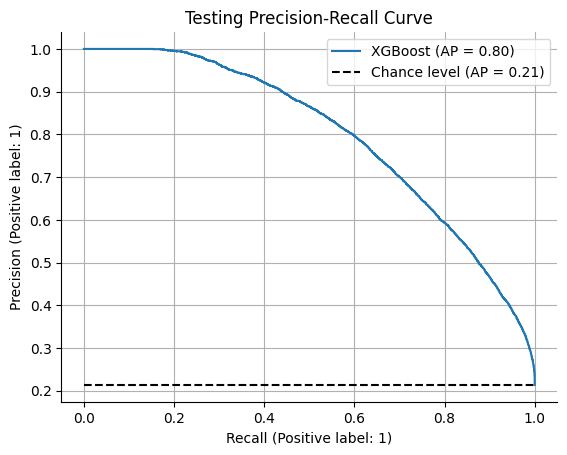

In [45]:
pred_proba = model_retrained.predict_proba(X_test_tf)

loss = log_loss(y_test, pred_proba[:, 1])
print(f"log loss: {loss:1.3f}")
disp = PrecisionRecallDisplay.from_estimator(
    model_retrained, X_test_tf, y_test, name="XGBoost", plot_chance_level=True
)
_ = disp.ax_.set_title(f"Testing Precision-Recall Curve")
plt.legend(loc=1)
plt.grid()
sns.despine()

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     44927
           1       0.70      0.70      0.70     12205

    accuracy                           0.87     57132
   macro avg       0.81      0.81      0.81     57132
weighted avg       0.87      0.87      0.87     57132



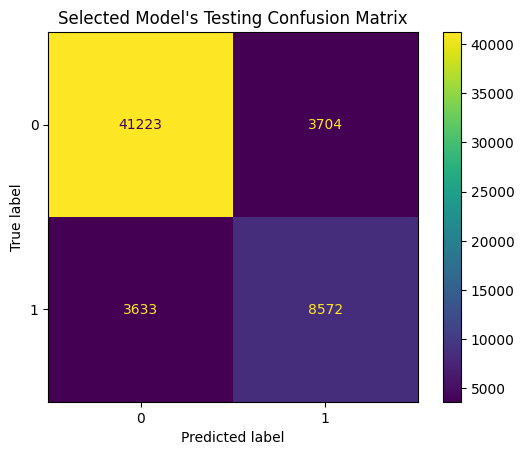

In [46]:
preds = np.where(pred_proba[:, 1] > PROFITABLE_THRESHOLD, 1, 0)
functions.report_classification_metrics(y_test, preds)
plt.title("Selected Model's Testing Confusion Matrix")
plt.show()

Testing is very successful - the PRC, confusion matrix and classification metrics are pretty much the same as in validation. However, retrospectively thinking about the train/test split - I should have split differently for this model. The split I did initially worked great for the TARGEt model, but here I would be more interested to test on the most recent loans, train and validate on the older ones.

## Deployment

### Ideas

Since currently the model only needs the application info, it is quite easy to deploy. We need to feed it the raw application data and the model will give us the answer. Some options to consider:
- API's output - the prediction and raw probability of refusal.
- Should we transform the raw probability somehow? Perhaps it should output level of certainty? Since our threshold is 0.35, it could make sense to translate 0.35 the 0% certainty and then increase certainty as predicted probability goes to 0 or 1.

### Deploy the Model

To run the API on local server:
- Navigate to app_refused/<br>
uvicorn app:app --reload
- http://127.0.0.1:8000/docs has an UI

Steps to get the model on Google Cloud:
- docker build -t NAME .
- docker tag NAME REPO_ON_GOOGLE/NAME
- docker push REPO_ON_GOOGLE/NAME
- (run on google cloud run)

Test the model I deployed:
- https://model-cxszazfxuq-nw.a.run.app/docs

Use this dictionary as test input:

{
  "SK_ID_PREV": 1946657,
  "AMT_ANNUITY": 7795.125,
  "AMT_APPLICATION": 147195,
  "AMT_CREDIT": 172840.5,
  "AMT_DOWN_PAYMENT": 0,
  "AMT_GOODS_PRICE": 147195,
  "WEEKDAY_APPR_PROCESS_START": "SUNDAY",
  "HOUR_APPR_PROCESS_START": 11,
  "FLAG_LAST_APPL_PER_CONTRACT": "Y",
  "NFLAG_LAST_APPL_IN_DAY": 1,
  "RATE_DOWN_PAYMENT": 0,
  "NAME_CASH_LOAN_PURPOSE": "XAP",
  "DAYS_DECISION": -1327,
  "NAME_PAYMENT_TYPE": "Cash through the bank",
  "NAME_TYPE_SUITE": "Unaccompanied",
  "NAME_CLIENT_TYPE": "New",
  "NAME_GOODS_CATEGORY": "Audio/Video",
  "NAME_PORTFOLIO": "POS",
  "NAME_PRODUCT_TYPE": "XNA",
  "CHANNEL_TYPE": "Country-wide",
  "SELLERPLACE_AREA": 2078,
  "NAME_SELLER_INDUSTRY": "Consumer electronics",
  "CNT_PAYMENT": 24,
  "NAME_YIELD_GROUP": "low_action",
  "PRODUCT_COMBINATION": "POS household without interest"
}

## Output From This Notebook

In this notebook, we our aim was to explore the possibility of modelling the status of a loan application. Here is how it went:
- We have created a binary target - whether the application was refused or not.
- Performed EDA using SweetViz.
- Applied statistical inference to two quite similar features - loan purpose and goods category. We found that goods category has a statistically significant impact on our defined target, while loan purpose doesn't at least when accounted for the confounding variable - loan amount.
- Did autoML using pycaret.
- Created a preprocessor pipeline, did feature selection and threshold selection.
- Analysed some sensitive applicants' information (like gender) impact on the model's predictions.
- Tested and deployed on Google Cloud.

Areas to improve:
- Since the problem is time-dependant, it could be good to train only on the latest applications if there's enough data for that. We should also test only on the freshest data, not a random sample.
- Aggregate the cash, credit, installments, also the previous applications and use them to enrich this dataset. This would require more intricate work for training the model than we have done in steps 2-3.

## Conclusions

In this project, I have achieved the following:
- Created the project workflow and brain-stormed three potential business problems, for two of which I have prepared ML solutions, and one is yet to be investigated.
- Performed EDA on the whole dataset.
- Attempted modelling the application TARGET feature in step 3. This has required to prepare a lot of aggregations from other tables in step 2.
- Created a fairly good model to predict whether the application should be refused or not.